<hr style="height:2px;">

# Demo: Denoising of 2D cell images

Copy this notebook into a directory in your Google drive.  

In this tutorial we will create a deep learning denoising model trained on data aquired by Pycro-Manager on your microscope. We will then used this denoising model to denoise images collected by Pycro-Manager in real time.   

We will be running image aquisition and inference locally, and train on a Google Colab GPU instance, though if you have a fairly powerful GPU locally feel free to train locally.

The deep learning model used in this tutorial is [N2V](https://github.com/juglab/n2v), which allows us to create a denoising algorithm without groud truth images by training on noisy images without clean targets. Check out how it works at https://arxiv.org/pdf/1811.10980.pdf.

Please install [Pycro-Manager](https://pycro-manager.readthedocs.io/en/latest/setup.html) locally before running this Colab notebook.

<hr style="height:2px;">

## Part 1: Connect to a local runtime

If you have not yet, install Pycro-Manager:   
```
pip install pycromanager
```

Open a terminal locally and run:
```
pip install --upgrade jupyter_http_over_ws>=0.0.7 && \
```
or if that does not work:
```
 pip install --upgrade jupyter_http_over_ws>=0.0.7 ; \
   jupyter serverextension enable --py jupyter_http_over_ws
```

Create a local jupyter runtime:
```
jupyter notebook --no-browser
```
Copy the backend URL. It should look something like http://localhost:8888/?token=SomthingElse.  
In the top right of this notebook click "Connect" then "Connect to local runtime". Enter your backend URL.


<hr style="height:2px;">

## Part 2: Collecting Training Images

First verify you have a working installation of [Pycro-Manager](https://pycro-manager.readthedocs.io/en/latest/setup.html). Open Micro-Manager, select tools-options, and check the box that says Run server on port 4827 (you only need to do this once). Run:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from pycromanager import Bridge
bridge = Bridge()
core = bridge.get_core()

The output should look something like:   
```
Out[1]: JavaObjectShadow for : mmcorej.CMMCore
```

It is important that the images we use to create the denoising use the same camera and imaging settings (gain, em-gain, read-out-parameters,...) as in your experiments.  
We recommend that you aquire 3-10 images. If your camera is higher resolution, or if you are not running this notebook with a GPU, we recommend using fewer images. In this tutorial we will be capturing images of a single scene though you may gain improved performance from capturing different samples and fields of view.

### Aquisition

Adjust your microscope to thge imaging settings (gain, em-gain, read-out-parameters,...) you plan to use in your experiments. Stage your sample.We will now collect the images and store them in a numpy array.   
Let's first try snapping a single image using the cell below. Make any adjustments needed.

JavaObjectShadow for : mmcorej.TaggedImage


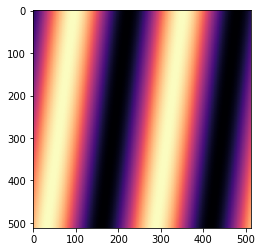

In [13]:
## Optional: Set microscope properties here. Here we set a property of 
## the core itself, but same code works for device properties
# auto_shutter = core.get_property('Core', 'AutoShutter')
# core.set_property('Core', 'AutoShutter', 0)

core.snap_image()
tagged_image = core.get_tagged_image()
pixels = np.reshape(tagged_image.pix, newshape=[tagged_image.tags['Height'], tagged_image.tags['Width']])
plt.imshow(pixels,cmap="magma")
print(tagged_image)

In [9]:
quantity = 6 # Adjust to number of images you would like to collect
dataRaw = []

while quantity >= 0:
  # The micro-manager core exposes several mechanisms foor acquiring images. In order to  not interfere
  # with other pycromanager functionality, this is the one that should be used
  core.snap_image()
  tagged_image = core.get_tagged_image()
  # If using micro-manager multi-camera adapter, use core.getTaggedImage(i), where i is the camera index
  # pixels by default come out as a 1D array. We can reshape them into an image
  pixels = np.reshape(tagged_image.pix, newshape=[tagged_image.tags['Height'], tagged_image.tags['Width']])
  dataRaw.append(pixels)
  quantity -= 1

dataRaw = np.array(dataRaw)

Let's save our data in a numpy array.

In [11]:
np.save("dataRaw.npy", dataRaw)

<hr style="height:2px;">

## Part 3: Creating the Model

If you have a Nvidia GPU and would like to train the model locally, feel free to skip to the next block of code. Else we would like to connect to a Colab runtime to utilize a free GPU instance.   

We want to enable GPU acceleration to speed up training. Under 'Runtime' dropdown in the left top bar, select 'change runtime type' and select 'GPU'.   

First disconnect from the local runtime using the dropdown in the top right, and switch the runtime  back to 'hosted'.

In [20]:
% tensorflow_version 1.x # CSBDeep is built on Tensorflow v1, if running locally run 'pip install tensorflow-gpu'
% nvidia-smi # Check that we are connected to a GPU
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x # CSBDeep is built on Tensorflow v1, if running locally run 'pip install tensorflow-gpu'`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


UsageError: Line magic function `%nvidia` not found.


In [55]:
% pip install n2v
from n2v.models import N2VConfig, N2V
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
datagen = N2V_DataGenerator()
from matplotlib import pyplot as plt
from matplotlib.image import imread, imsave
from PIL import Image
import numpy as np
import os

Upload `dataRaw.npy` from the directory you started your local runtime to the Colab notebook directory using the 'file' button on the left side-menu.

In [77]:
imgs = np.load('/content/dataRaw.npy')
testImg = imgs[0]
for im in range(1,len(imgs)):
  Image.fromarray(imgs[im]).save(str(im)+'.tif')
  # imsave(str(im)+'.tif', imgs[im])
imgs = datagen.load_imgs_from_directory('/content', filter='*.tif', dims='YX')
# imgs = [1:]
# # If on local runtime use:
# imgs = np.load('dataRaw.npy')

Check that we can view our images.

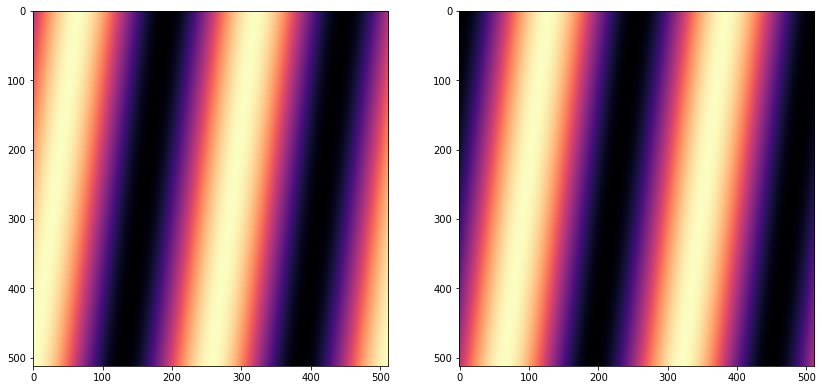

In [64]:
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(imgs[0][0,...,0], cmap='magma')
plt.subplot(1,2,2)
plt.imshow(imgs[6][0,...,0], cmap='magma')

In [69]:
patches = []
patches = datagen.generate_patches_from_list(imgs, shape=(64,64), shuffle=True)

divide = int(len(patches)/8)
train_patches = patches[divide:]
val_patches = patches[:divide]
print(len(train_patches))
print(len(val_patches))
print(len(patches))

Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
3136
448
3584


Let's look at one of our training and validation patches.

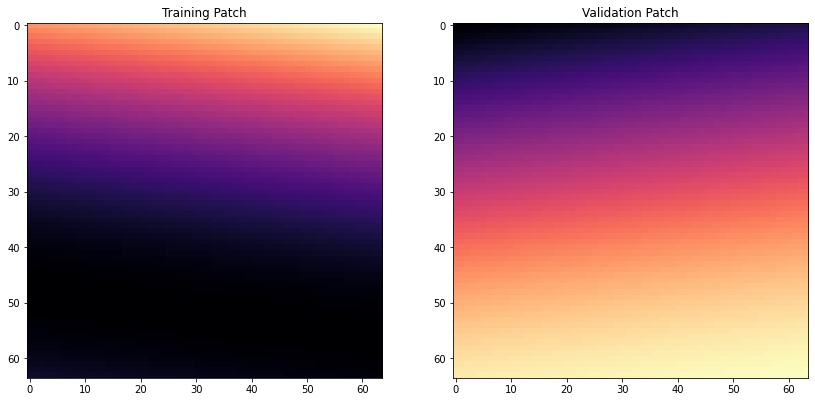

In [70]:
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(train_patches[0,...,0], cmap='magma')
plt.title('Training Patch');
plt.subplot(1,2,2)
plt.imshow(val_patches[0,...,0], cmap='magma')
plt.title('Validation Patch');

Let's configure our model. We very strongly recommend that you not train for more than 120 epochs on Colab as the system will time out after 12 hours. Make sure not to close your browser or after 90 minutes this notebook's data will be erased.

In [71]:
config = N2VConfig(train_patches, unet_n_depth=3, unet_kern_size=3, train_steps_per_epoch=300, train_epochs=80, 
                   train_learning_rate=0.0005, train_loss='mse', batch_norm=True, train_batch_size=128, 
                   n2v_perc_pix=0.198, n2v_patch_shape=(64, 64), unet_n_first = 96, 
                   unet_residual = True, n2v_manipulator='uniform_withCP')
vars(config)

{'axes': 'YXC',
 'batch_norm': True,
 'means': ['3281.6335'],
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': 5,
 'n2v_patch_shape': (64, 64),
 'n2v_perc_pix': 0.198,
 'n_channel_in': 1,
 'n_channel_out': 1,
 'n_dim': 2,
 'probabilistic': False,
 'stds': ['1815.2402'],
 'train_batch_size': 128,
 'train_checkpoint': 'weights_best.h5',
 'train_epochs': 8,
 'train_learning_rate': 0.0005,
 'train_loss': 'mse',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10},
 'train_steps_per_epoch': 3,
 'train_tensorboard': True,
 'unet_input_shape': (None, None, 1),
 'unet_kern_size': 3,
 'unet_last_activation': 'linear',
 'unet_n_depth': 3,
 'unet_n_first': 96,
 'unet_residual': True}

Mount Google Drive. We will save our model to a folder in Drive to not loose it when we close this Colab notebook.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [74]:
model_name = 'n2v_fluorescence_microscopy'
model_dir = '/content/gdrive/My Drive/denoising_model'
# We are now creating our network model.
model = N2V(config=config, name=model_name, basedir=model_dir)

Time to train our model. Make sure not to close this notebook during training if you are using a hosted runtime. This may take a while, around 11 hours for 100 epochs with the provided settings.

In [75]:
history = model.train(train_patches, val_patches)


8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 448/448 [00:00<00:00, 2165.53it/s]




The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




Epoch 1/8
3/3 [==============================] - 27s 9s/step - loss: 1.1850 - n2v_mse: 1.1850 - n2v_abs: 0.8804 - val_loss: 45.5241 - val_n2v_mse: 45.5241 - val_n2v_abs: 4.8440

Epoch 2/8
3/3 [==============================] - 8s 3s/step - loss: 0.3483 - n2v_mse: 0.3483 - n2v_abs: 0.4486 - val_loss: 7.9373 - val_n2v_mse: 7.9373 - val_n2v_abs: 1.9082
Epoch 3/8
3/3 [==============================] - 5s 2s/step - loss: 0.0976 - n2v_mse: 0.0976 - n2v_abs: 0.2488 - val_loss: 7.2403 - val_n2v_mse: 7.2403 - val_n2v_abs: 1.5725
Epoch 4/8
3/3 [==============================] - 5s 2s/step - loss: 0.0405 - n2v_mse: 0.0405 - n2v_abs: 0

Let's test our fresh model on an image we collected earlier.

The input image is of type uint16 and will be casted to float32 for prediction.


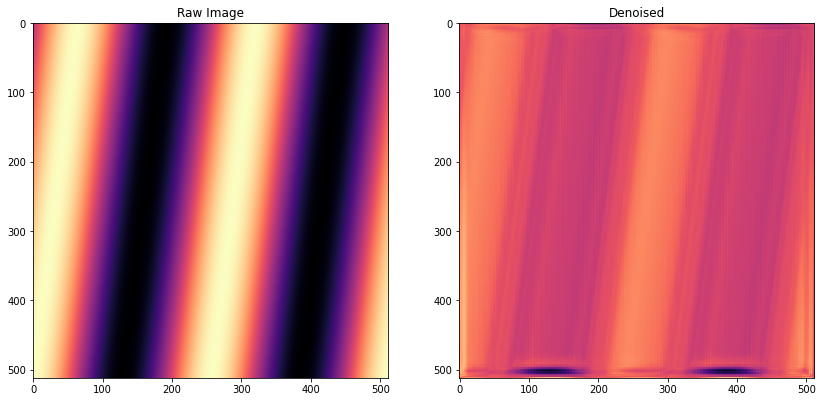

In [78]:
pred = model.predict(testImg, axes='YX')
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(testImg, cmap='magma')
plt.title('Raw Image');
plt.subplot(1,2,2)
plt.imshow(pred, cmap='magma')
plt.title('Denoised');

<hr style="height:2px;">

## Part 4: Testing our Model
Now let's test using our algorithm and denoise images collected in real time using Pycro-Manager!   

First, start and reconnect to a local runtime. Download the folder `denoising_model` from your Google Drive to the current working directory of your local runtime.   

Let's load our model.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from n2v.models import N2VConfig, N2V
from pycromanager import Bridge, Acquisition, multi_d_acquisition_events
bridge = Bridge()
bridge.get_core()

model_name = 'n2v_fluorescence_microscopy'
basedir = './'
# We are now creating our network model.
model = N2V(config=None, name=model_name, basedir=basedir)

Create a Pycro-Manager [image processor](https://pycro-manager.readthedocs.io/en/latest/img_processors.html) that applies the deep learning model we created to images.

In [ ]:
def img_process_fn(image, metadata):
  metadata['a_new_metadata_key'] = 'a new value'
  image = model.predict(img, axes='YX')
  plt.imshow(image, cmap='magma')

  # propogate the image and metadata to the default viewer and saving classes
  return image, metadata

Let's aquire an image!

In [ ]:
directory_to_save_images = '/aquisitions_tmp'
if __name__ == '__main__': #this is important, don't forget it
  with Acquisition(directory=directory_to_save_images, name='acquisition_1', image_process_fn=img_process_fn) as acq:
    acq.aquire()

Let's view our denoised image!

In [ ]:
img = imread('/aquisitions_tmp/acquisition_1.png')
plt.imshow(img, cmap='magma')